<a href="https://colab.research.google.com/github/SurajBhar/Segmentation/blob/main/Copy_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 918.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=6c41181e817ad74a4b936d8e6db17db1e85268eaa49883ca17548ef4279c5ff9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=b0a50e024668f7767fcc993d15f8d46dab9d60c7eb3e5af0fa67574c36bafe09
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumen

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (3/3), done.


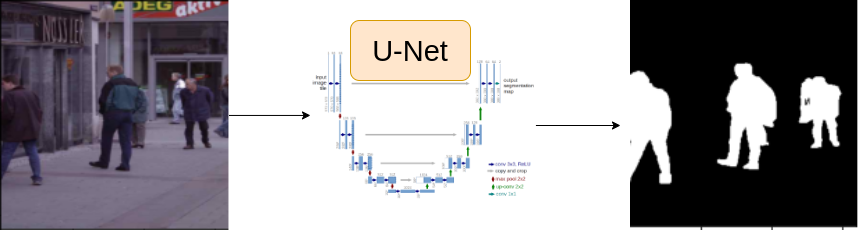

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[0]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

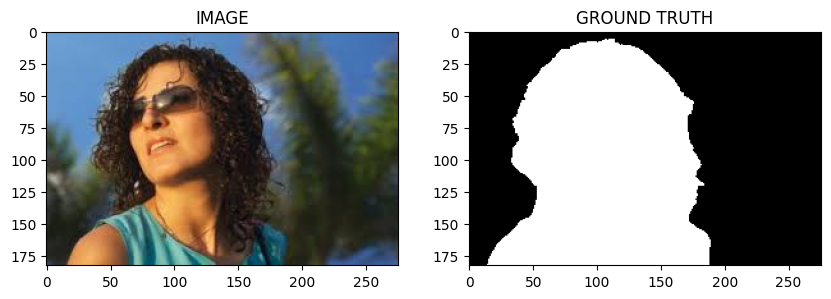

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes= False)

def get_valid_augs():
  return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE)], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h,w,c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask) # data is a dict, key = image, value = image
      image = data['image']
      mask = data['mask']

    # Pytorch use [C, H, W] convention --> Change to required format
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [13]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [14]:
img, msk = validset[33]
print(img.shape)
print(msk.shape)

torch.Size([3, 320, 320])
torch.Size([1, 320, 320])


In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


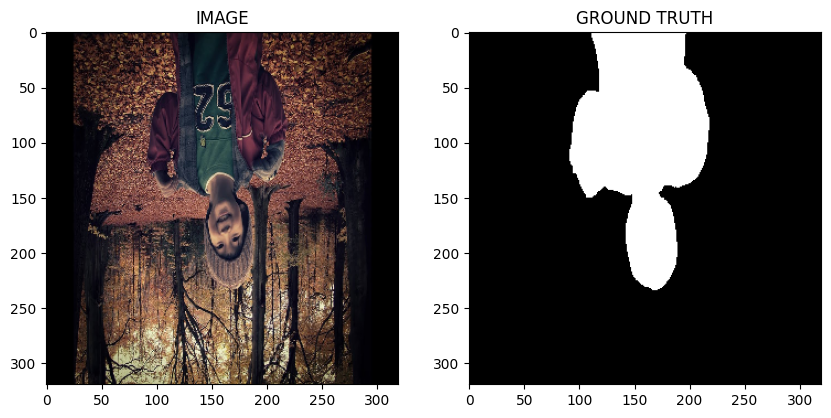

In [16]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True, )
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f"Total Number of batches in trainloader : {len(trainloader)}")
print(f"Total Number of batches in validloader : {len(validloader)}")

Total Number of batches in trainloader : 15
Total Number of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights=WEIGHTS,
        in_channels= 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2

    return logits


In [23]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 55.6MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [28]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images , masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [32]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images , masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR )

In [34]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved Model")
    best_valid_loss = valid_loss
  print(f"Epoch:{i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Saved Model
Epoch:1 Train_loss : 0.42496692935625713 Valid_loss : 0.33142751082777977


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch:2 Train_loss : 0.3054555982351303 Valid_loss : 0.3466564565896988


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


Saved Model
Epoch:3 Train_loss : 0.2558126707871755 Valid_loss : 0.24629201740026474


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Saved Model
Epoch:4 Train_loss : 0.2111783097187678 Valid_loss : 0.2070130743086338


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


Epoch:5 Train_loss : 0.19078313708305358 Valid_loss : 0.24605629593133926


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Saved Model
Epoch:6 Train_loss : 0.16441107590993245 Valid_loss : 0.2012467384338379


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch:7 Train_loss : 0.20785501499970754 Valid_loss : 0.2649381347000599


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch:8 Train_loss : 0.22865339914957683 Valid_loss : 0.21961360052227974


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch:9 Train_loss : 0.22125271658102671 Valid_loss : 0.22052272222936153


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


Epoch:10 Train_loss : 0.21389312992493312 Valid_loss : 0.3564065545797348


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch:11 Train_loss : 0.23666834632555644 Valid_loss : 0.24394585378468037


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch:12 Train_loss : 0.1509423092007637 Valid_loss : 0.20766093209385872


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Saved Model
Epoch:13 Train_loss : 0.1301654691497485 Valid_loss : 0.18886064738035202


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch:14 Train_loss : 0.10773812830448151 Valid_loss : 0.2077909503132105


100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch:15 Train_loss : 0.10629424850145976 Valid_loss : 0.2028079368174076


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch:16 Train_loss : 0.13795611610015232 Valid_loss : 0.22178935259580612


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch:17 Train_loss : 0.15661544551452 Valid_loss : 0.29462163150310516


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch:18 Train_loss : 0.15739989131689072 Valid_loss : 0.25158872455358505


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch:19 Train_loss : 0.145030743877093 Valid_loss : 0.1968363169580698


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Saved Model
Epoch:20 Train_loss : 0.11755360662937164 Valid_loss : 0.1799289658665657


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch:21 Train_loss : 0.11405166685581207 Valid_loss : 0.18770557641983032


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Saved Model
Epoch:22 Train_loss : 0.09811936368544896 Valid_loss : 0.16250595822930336


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch:23 Train_loss : 0.09010719656944274 Valid_loss : 0.17543486133217812


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Saved Model
Epoch:24 Train_loss : 0.08499187429745993 Valid_loss : 0.15803059563040733


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

Epoch:25 Train_loss : 0.08908904194831849 Valid_loss : 0.17110924795269966


# Task 9 : Inference

In [37]:
idx = 21

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)* 1.0

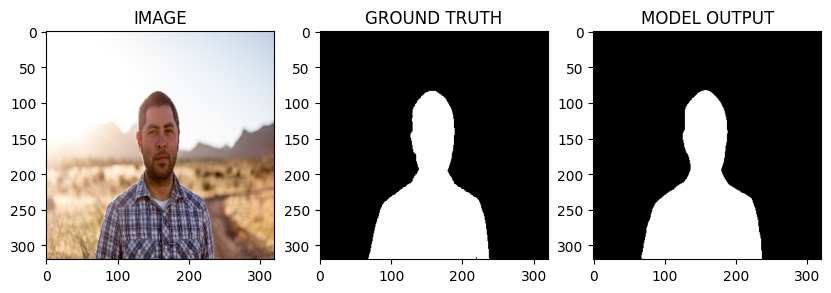

In [38]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya